In [28]:
%matplotlib inline
# RESEARCH IN PYTHON: INSTRUMENTAL VARIABLES ESTIMATION
# by J. NATHAN MATIAS March 18, 2015

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# THE SOFTWARE.

# THINGS TO IMPORT
# This is a good baseline set of libraries to import by default if you're rushed for time.

import codecs                     # load UTF-8 Content
import json                       # load JSON files
import pandas as pd               # Pandas handles dataframes
import numpy as np                # Numpy handles lots of basic maths operations
import matplotlib.pyplot as plt   # Matplotlib for plotting
import seaborn as sns             # Seaborn for beautiful plots
from dateutil import *            # I prefer dateutil for parsing dates
import math                       # transformations
import statsmodels.formula.api as smf  # for doing statistical regression
import statsmodels.api as sm      # access to the wider statsmodels library, including R datasets
from collections import Counter   # Counter is useful for grouping and counting
import scipy

# Instrumental Variables Estimation

This section is taken from [Chapter 10](http://www.ats.ucla.edu/stat/stata/examples/methods_matter/chapter10/default.htm) of [Methods Matter](http://www.ats.ucla.edu/stat/examples/methods_matter/) by Richard Murnane and John Willett. The descriptions are taken from Wikipedia, for copyright reasons.

In statistics, econometrics, epidemiology and related disciplines, the method of instrumental variables (IV) is used to estimate causal relationships when controlled experiments are not feasible or when a treatment is not successfully delivered to every unit in a randomized experiment.

In linear models, there are two main requirements for using an IV:

* The instrument *must* be correlated with the *endogenous explanatory variables*, conditional on the other covariates.
* The instrument *cannot* be correlated with the *error term* in the explanatory equation (conditional on the other covariates), that is, the instrument cannot suffer from the same problem as the original predicting variable.


# Example: Predicting Civic Engagement from College Attainment

Can we use college attainment (COLLEGE) to predict the probability of civic engagement (REGISTER)? College attainment is not randomized, and the arrow of causality may move in the opposite direction, so all we can do with standard regression is to establish a correlation.

In this example, we use an _Instrumental Variable_ of distance between the student's school and a community college (DISTANCE), to estimate a causal relationship. This is possible only if this variable is related to college attainment and NOT related to the residuals of regressing COLLEGE on REGISTER. 

The python code listed here is roughly parallel to [the code listed in the textbook example](http://www.ats.ucla.edu/stat/stata/examples/methods_matter/chapter10/default.htm) for Methods Matter Chapter 10. If you're curious about how to do a similar example in R, check out "[A Simple Instrumental Variables Problem](http://www.r-bloggers.com/a-simple-instrumental-variables-problem/)" by Adam Hyland in R-Bloggers or Ani Katchova's "[Instrumental Variables in R](https://www.youtube.com/watch?v=OwM3BgWEgUg) video on YouTube.

# Acquire Dee Dataset from Methods Matter

In [29]:
import urllib2
import os.path
if(os.path.isfile("dee.dta")!=True):
    response = urllib2.urlopen("http://www.ats.ucla.edu/stat/stata/examples/methods_matter/chapter10/dee.dta")
    if(response.getcode()==200):
        f = open("dee.dta","w")
        f.write(response.read())
        f.close()
dee_df = pd.read_stata("dee.dta")

# Summary Statistics

In [30]:
dee_df[['register','college', 'distance']].describe()

,register,college,distance
count,9227.000000,9227.000000,9227.000000
mean,0.670857,0.547090,9.735992
std,0.469927,0.497805,8.702286
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,3.000000
50%,1.000000,1.000000,7.000000
75%,1.000000,1.000000,15.000001
max,1.000000,1.000000,35.000000


# Cross-Tabulation

In [31]:
print pd.crosstab(dee_df.register, dee_df.college)
chi2 = scipy.stats.chi2_contingency(pd.crosstab(dee_df.register, dee_df.college))
print "chi2: %(c)d" % {"c":chi2[0]}
print "p: %(p)0.03f" % {"p":chi2[1]}
print "df: %(df)0.03f" % {"df":chi2[2]}
print "expected:"
print chi2[3]

college      0     1
register            
0         1780  1257
1         2399  3791
chi2: 323
p: 0.000
df: 1.000
expected:
[[ 1375.48748239  1661.51251761]
 [ 2803.51251761  3386.48748239]]


# Correlation Matrix

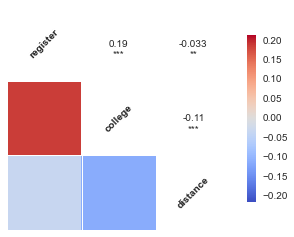

In [32]:
sns.corrplot(dee_df[['register','college','distance']])

# Linear Regression of REGISTER on COLLEGE

In [33]:
result = smf.ols(formula = "register ~ college", data = dee_df).fit()
print result.summary()


                            OLS Regression Results                            
Dep. Variable:               register   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     335.9
Date:                Wed, 18 Mar 2015   Prob (F-statistic):           1.03e-73
Time:                        22:15:12   Log-Likelihood:                -5959.0
No. Observations:                9227   AIC:                         1.192e+04
Df Residuals:                    9225   BIC:                         1.194e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.5741      0.007     80.391      0.0

# Two-Stage Least Squares Regression of REGISTER ~ COLLEGE where IV=DISTANCE
###using statsmodels.formula.api.ols

In two-stage least squares regression, we regress COLLEGE on DISTANCE and use the predictions from that model as the predictors for REGISTER.

In [34]:
print "=============================================================================="
print "                                  FIRST STAGE"
print "=============================================================================="
result = smf.ols(formula = "college ~ distance", data = dee_df).fit()
print result.summary()
dee_df['college_fitted'] = result.predict()

print
print
print "=============================================================================="
print "                                  SECOND STAGE"
print "=============================================================================="

result = smf.ols(formula = "register ~ college_fitted", data=dee_df).fit()
print result.summary()

                                  FIRST STAGE
                            OLS Regression Results                            
Dep. Variable:                college   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     115.9
Date:                Wed, 18 Mar 2015   Prob (F-statistic):           7.35e-27
Time:                        22:15:12   Log-Likelihood:                -6598.2
No. Observations:                9227   AIC:                         1.320e+04
Df Residuals:                    9225   BIC:                         1.321e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Interc

^^^^^^ Not sure what's going on with the R2 statistic here (it's 0.001 here, versus 0.022 in the example), although everything else matches what we see from the Stata output in the published example 

# Adding Covariates that do not satisfy the requirements of instrumental variables

In the case of the covariate of race/ethicity, we expect that there might be a relationship between race/ethnicity and distance to a community college, as well as a relationship between race/ethnicity and voter registration. 

While race/ethnicity fails the test for instrumental variables, it can still be included as a covariate in a multiple regression model. In such cases, it is essential to include covariates at both stages of a two-stage test.

## Correlation Matrix

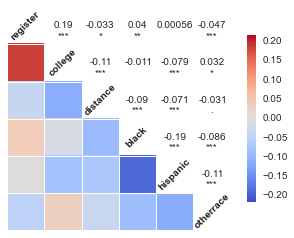

In [35]:
sns.corrplot(dee_df[['register','college','distance', 'black','hispanic','otherrace']])

## Two-Stage Least Squares Regression of REGISTER ~ COLLEGE + BLACK + HISPANIC + OTHERRACE where IV=DISTANCE

In [36]:
print "=============================================================================="
print "                                  FIRST STAGE"
print "=============================================================================="
result = smf.ols(formula = "college ~ distance + black + hispanic + otherrace", data = dee_df).fit()
print result.summary()
dee_df['college_fitted'] = result.predict()

print
print
print "=============================================================================="
print "                                  SECOND STAGE"
print "=============================================================================="

result = smf.ols(formula = "register ~ college_fitted + black + hispanic + otherrace", data=dee_df).fit()
print result.summary()

                                  FIRST STAGE
                            OLS Regression Results                            
Dep. Variable:                college   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     51.24
Date:                Wed, 18 Mar 2015   Prob (F-statistic):           9.75e-43
Time:                        22:15:20   Log-Likelihood:                -6554.4
No. Observations:                9227   AIC:                         1.312e+04
Df Residuals:                    9222   BIC:                         1.315e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Interc

# Interactions Between the Endogenous Question Predictor and Exogenous Covariates in the Second Stage Model

In this case, we explore whether interactions between college and race/ethnicity are significant predictors of voter registration. Here, it's important to meet the "rank condition": that "for every endogenous predictor included in the second stage, there must be at least one instrument included in the first stage."

To do this, we need to create a series of stage-one instruments, one for the main effect, and one for each interaction. In 

In [37]:
print "=============================================================================="
print "                                  FIRST STAGE"
print "=============================================================================="
# generate the stage one main effect instrument
result = smf.ols(formula = "college ~ distance + black + hispanic + otherrace +" +
                 "distance:black + distance:hispanic + distance:otherrace", data = dee_df).fit()
dee_df['college_fitted'] = result.predict()
print result.summary()

# generate the stage one interaction instrument for distance:black
# note that we have DROPPED the irrelevant terms. 
# The full form for each interaction, which gives the exact same result, is:
# result = smf.ols(formula = "college:black ~ distance + black + hispanic + otherrace +" +
#                 "distance:black + distance:hispanic + distance:otherrace", data = dee_df).fit()

result = smf.ols(formula = "college:black ~ distance + black + distance:black", data = dee_df).fit()
dee_df['collegeXblack'] = result.predict()


# generate the stage one interaction instrument for distance:hispanic
result = smf.ols(formula = "college:hispanic ~ distance + hispanic + distance:hispanic", data = dee_df).fit()
dee_df['collegeXhispanic'] = result.predict()

# generate the stage one interaction instrument for distance:hispanic
result = smf.ols(formula = "college:otherrace ~ distance + otherrace + distance:otherrace", data = dee_df).fit()
dee_df['collegeXotherrace'] = result.predict()

# generate the final model, that includes these interactions as predictors
result = smf.ols(formula = "register ~ college_fitted + black + hispanic + otherrace +" +
                 "collegeXblack + collegeXhispanic + collegeXotherrace", data = dee_df).fit()
print result.summary()

                                  FIRST STAGE
                            OLS Regression Results                            
Dep. Variable:                college   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     29.57
Date:                Wed, 18 Mar 2015   Prob (F-statistic):           1.12e-40
Time:                        22:15:20   Log-Likelihood:                -6553.3
No. Observations:                9227   AIC:                         1.312e+04
Df Residuals:                    9219   BIC:                         1.318e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------

^^^ in this particular case, we find no significant interactions and fall back on our previous model, which simply included race/ethnicity as a covariate

# Binomial Regression: Logistic Model

In this example, we use a logistic model with a two-stage least-squares regression. NOTE: This is not attempted in the textbook example, so I cannot be completely certain about this, unlike the above results.

In [38]:
print "=============================================================================="
print "                                  FIRST STAGE"
print "=============================================================================="
result = smf.glm(formula = "college ~ distance + black + hispanic + otherrace", 
                 data=dee_df,
                 family=sm.families.Binomial()).fit()
print result.summary()
dee_df['college_fitted'] = result.predict()

print
print
print "=============================================================================="
print "                                  SECOND STAGE"
print "=============================================================================="#
result = smf.glm(formula = "register ~ college_fitted + black + hispanic + otherrace",
                 data=dee_df,
                 family=sm.families.Binomial()).fit()
print result.summary()

                                  FIRST STAGE
                 Generalized Linear Model Regression Results                  
Dep. Variable:                college   No. Observations:                 9227
Model:                            GLM   Df Residuals:                     9222
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -6253.9
Date:                Wed, 18 Mar 2015   Deviance:                       12508.
Time:                        22:15:20   Pearson chi2:                 9.23e+03
No. Iterations:                     6                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.5840      0.038     15.447      0.000         0.510     0.658
distan

# Binomial Regression: Probit Model

In this example, we use a probit model with a two-stage least-squares regression. NOTE: This is not attempted in the textbook example, so I cannot be completely certain about this, unlike the above results.

In [39]:
import patsy
print "=============================================================================="
print "                                  FIRST STAGE"
print "=============================================================================="
a,b = patsy.dmatrices("college ~ distance + black + hispanic + otherrace",
                      dee_df,return_type="dataframe")
result = sm.Probit(a,b).fit()
print result.summary()
dee_df['college_fitted'] = result.predict()


print
print
print "=============================================================================="
print "                                  SECOND STAGE"
print "=============================================================================="#

a,b = patsy.dmatrices("register ~ college_fitted + black + hispanic + otherrace",
                      dee_df,return_type="dataframe")
result = sm.Probit(a,b).fit()

print result.summary()

                                  FIRST STAGE
Optimization terminated successfully.
         Current function value: 0.677791
         Iterations 4
                          Probit Regression Results                           
Dep. Variable:                college   No. Observations:                 9227
Model:                         Probit   Df Residuals:                     9222
Method:                           MLE   Df Model:                            4
Date:                Wed, 18 Mar 2015   Pseudo R-squ.:                 0.01585
Time:                        22:15:20   Log-Likelihood:                -6254.0
converged:                       True   LL-Null:                       -6354.7
                                        LLR p-value:                 1.862e-42
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.3640      0.023     15.566      0.000        